<h3>导入包</h3>

In [1]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [2]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [3]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)

<h4>读入C榜数据</h4>

In [4]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_Final/' + name + '_EC_Final.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.085938
 668 2015-08-17 23:00:00  0.128906
 669 2015-08-17 23:15:00  0.082031
 670 2015-08-17 23:30:00  0.144531
 671 2015-08-17 23:45:00  0.093750
 
 [64744 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.000000
 668 2015-08-17 23:00:00  0.000000
 669 2015-08-17 23:15:00  0.000000
 670 2015-08-17 23:30:00  0.000000
 671 2015-08-17 23:45:00  0.000000
 
 [64992 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [5]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [6]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
64504,2015-08-17 22:45:00,0.085938,0.000000,0.089844,0.265625,1.937500
64505,2015-08-17 23:00:00,0.128906,0.000000,0.140625,0.265625,1.750000
64506,2015-08-17 23:15:00,0.082031,0.000000,0.093750,0.265625,1.843750
64507,2015-08-17 23:30:00,0.144531,0.000000,0.156250,0.265625,1.687500


<h4>将一二层数据相加</h4>

In [7]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [8]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-14 13:45:00,NaN,NaN,NaN,NaN
2014-03-14 14:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-04-23 19:15:00,NaN,NaN,NaN,NaN
2014-04-23 19:30:00,NaN,NaN,NaN,NaN
2014-04-23 19:45:00,NaN,NaN,NaN,NaN
2014-04-23 20:00:00,NaN,NaN,NaN,NaN


In [9]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-11-17 08:30:00,NaN,NaN,NaN,NaN
2014-11-17 08:45:00,NaN,NaN,NaN,NaN
2014-11-17 09:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-12-10 16:15:00,NaN,NaN,NaN,NaN
2014-12-10 16:30:00,NaN,NaN,NaN,NaN
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [10]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [11]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [12]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

,value_air,value_socket,value_light,value_total
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-17 19:00:00,8.187500,1.015625,1.187500,10.390625
2015-08-17 20:00:00,8.031250,1.000000,0.937500,9.968750
2015-08-17 21:00:00,8.656250,1.007812,1.046875,10.710938
2015-08-17 22:00:00,7.468750,0.949219,1.156250,9.574219


<AxesSubplot:>

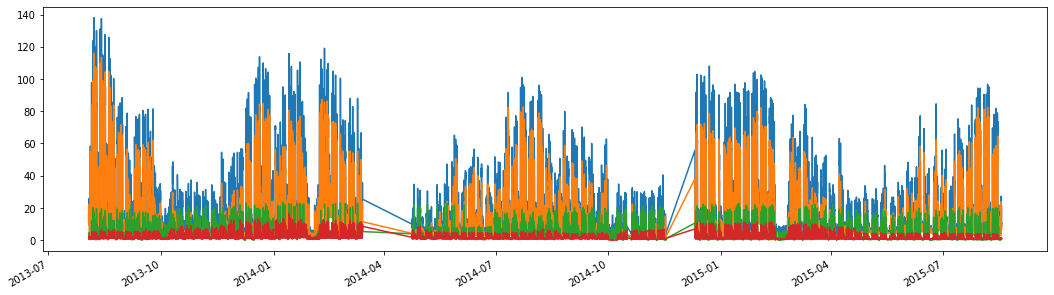

In [13]:
data["value_total"].plot(figsize=(18,5))
data["value_air"].plot(figsize=(18,5))
data["value_light"].plot(figsize=(18,5))
data["value_socket"].plot(figsize=(18,5))

<h3>合并天气数据</h3>

In [14]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [15]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [16]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["temp"] = data["temp"].rolling("12H").mean()
data["is_summer"] = data["month"].apply(lambda x: x in (6, 7, 8)).astype(int)
data["is_winter"] = data["month"].apply(lambda x: x in (12, 1, 2)).astype(int)
# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud,workday,hour,week,day,month,year,is_summer,is_winter
time,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,东南风,159,9,71,0,0,5,3,8,2013,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,东南风,155,8,75,0,1,5,3,8,2013,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,东南风,150,8,54,0,2,5,3,8,2013,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,东南风,151,8,25,0,3,5,3,8,2013,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,东南风,151,8,35,0,4,5,3,8,2013,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,东北风,43,11,1,1,19,0,24,8,2015,1,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,东北风,45,9,0,1,20,0,24,8,2015,1,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,东北风,35,7,2,1,21,0,24,8,2015,1,0


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [17]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,is_summer,is_winter,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,159,9,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,155,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,150,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,151,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,151,8,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,1,0,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,1,0,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,1,0,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [18]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,159,9,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,155,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,150,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [19]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [20]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_metric(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))[1]
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [21]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [22]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [23]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [24]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

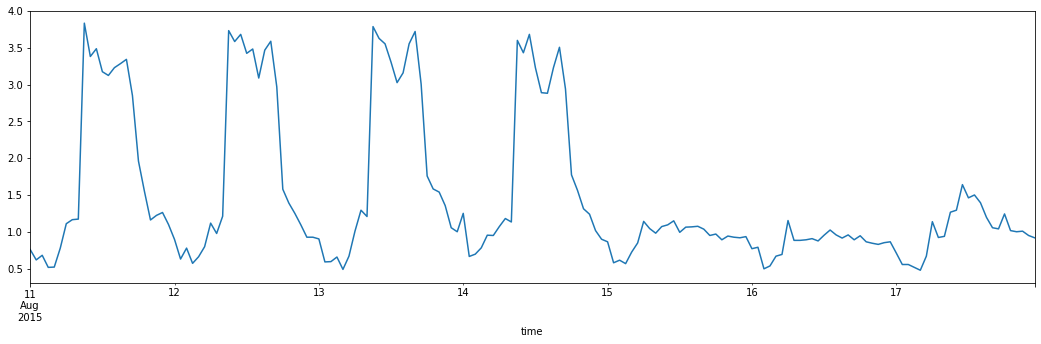

In [25]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [26]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [27]:
model_socket1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [28]:
socket_pred2 = data_socket.loc[: "2015-08-10 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [29]:
model_socket3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.063462
0:	learn: 1.9030196	total: 66.2ms	remaining: 1m 6s
1:	learn: 1.8142047	total: 68.3ms	remaining: 34.1s
2:	learn: 1.7326982	total: 70.2ms	remaining: 23.3s
3:	learn: 1.6572363	total: 72.2ms	remaining: 18s
4:	learn: 1.5870657	total: 74.2ms	remaining: 14.8s
5:	learn: 1.5229072	total: 76.2ms	remaining: 12.6s
6:	learn: 1.4636623	total: 78.2ms	remaining: 11.1s
7:	learn: 1.4087895	total: 80.1ms	remaining: 9.93s
8:	learn: 1.3591124	total: 82.1ms	remaining: 9.04s
9:	learn: 1.3131031	total: 84ms	remaining: 8.32s
10:	learn: 1.2714622	total: 85.9ms	remaining: 7.72s
11:	learn: 1.2334265	total: 87.9ms	remaining: 7.24s
12:	learn: 1.1985942	total: 89.9ms	remaining: 6.82s
13:	learn: 1.1671244	total: 91.9ms	remaining: 6.47s
14:	learn: 1.1383188	total: 93.9ms	remaining: 6.16s
15:	learn: 1.1129108	total: 95.8ms	remaining: 5.89s
16:	learn: 1.0892572	total: 97.8ms	remaining: 5.65s
17:	learn: 1.0673432	total: 99.7ms	remaining: 5.44s
18:	learn: 1.0477077	total: 102ms	remaining: 5.2

243:	learn: 0.5766107	total: 545ms	remaining: 1.69s
244:	learn: 0.5761248	total: 547ms	remaining: 1.68s
245:	learn: 0.5753979	total: 549ms	remaining: 1.68s
246:	learn: 0.5747183	total: 550ms	remaining: 1.68s
247:	learn: 0.5739192	total: 553ms	remaining: 1.68s
248:	learn: 0.5731259	total: 554ms	remaining: 1.67s
249:	learn: 0.5727524	total: 556ms	remaining: 1.67s
250:	learn: 0.5725475	total: 558ms	remaining: 1.67s
251:	learn: 0.5721497	total: 560ms	remaining: 1.66s
252:	learn: 0.5719626	total: 562ms	remaining: 1.66s
253:	learn: 0.5715456	total: 564ms	remaining: 1.66s
254:	learn: 0.5713243	total: 566ms	remaining: 1.65s
255:	learn: 0.5707595	total: 568ms	remaining: 1.65s
256:	learn: 0.5701961	total: 570ms	remaining: 1.65s
257:	learn: 0.5698475	total: 572ms	remaining: 1.64s
258:	learn: 0.5693969	total: 574ms	remaining: 1.64s
259:	learn: 0.5691563	total: 575ms	remaining: 1.64s
260:	learn: 0.5689495	total: 577ms	remaining: 1.63s
261:	learn: 0.5684580	total: 579ms	remaining: 1.63s
262:	learn: 

434:	learn: 0.5094525	total: 908ms	remaining: 1.18s
435:	learn: 0.5093055	total: 910ms	remaining: 1.18s
436:	learn: 0.5087806	total: 912ms	remaining: 1.17s
437:	learn: 0.5085420	total: 914ms	remaining: 1.17s
438:	learn: 0.5083358	total: 916ms	remaining: 1.17s
439:	learn: 0.5080375	total: 918ms	remaining: 1.17s
440:	learn: 0.5078319	total: 920ms	remaining: 1.17s
441:	learn: 0.5076958	total: 922ms	remaining: 1.16s
442:	learn: 0.5072708	total: 924ms	remaining: 1.16s
443:	learn: 0.5069877	total: 926ms	remaining: 1.16s
444:	learn: 0.5067345	total: 927ms	remaining: 1.16s
445:	learn: 0.5065543	total: 929ms	remaining: 1.15s
446:	learn: 0.5061665	total: 931ms	remaining: 1.15s
447:	learn: 0.5059247	total: 933ms	remaining: 1.15s
448:	learn: 0.5057726	total: 935ms	remaining: 1.15s
449:	learn: 0.5053103	total: 937ms	remaining: 1.15s
450:	learn: 0.5049985	total: 939ms	remaining: 1.14s
451:	learn: 0.5047015	total: 941ms	remaining: 1.14s
452:	learn: 0.5044437	total: 943ms	remaining: 1.14s
453:	learn: 

636:	learn: 0.4663581	total: 1.29s	remaining: 737ms
637:	learn: 0.4661853	total: 1.3s	remaining: 735ms
638:	learn: 0.4660638	total: 1.3s	remaining: 733ms
639:	learn: 0.4658085	total: 1.3s	remaining: 731ms
640:	learn: 0.4656197	total: 1.3s	remaining: 729ms
641:	learn: 0.4654097	total: 1.3s	remaining: 727ms
642:	learn: 0.4651866	total: 1.31s	remaining: 725ms
643:	learn: 0.4649498	total: 1.31s	remaining: 723ms
644:	learn: 0.4646858	total: 1.31s	remaining: 721ms
645:	learn: 0.4645234	total: 1.31s	remaining: 719ms
646:	learn: 0.4643501	total: 1.31s	remaining: 717ms
647:	learn: 0.4640661	total: 1.32s	remaining: 715ms
648:	learn: 0.4639843	total: 1.32s	remaining: 713ms
649:	learn: 0.4637662	total: 1.32s	remaining: 711ms
650:	learn: 0.4636701	total: 1.32s	remaining: 709ms
651:	learn: 0.4635670	total: 1.32s	remaining: 706ms
652:	learn: 0.4634021	total: 1.32s	remaining: 704ms
653:	learn: 0.4633374	total: 1.33s	remaining: 702ms
654:	learn: 0.4632514	total: 1.33s	remaining: 700ms
655:	learn: 0.463

819:	learn: 0.4388736	total: 1.65s	remaining: 361ms
820:	learn: 0.4388015	total: 1.65s	remaining: 359ms
821:	learn: 0.4387204	total: 1.65s	remaining: 357ms
822:	learn: 0.4385242	total: 1.65s	remaining: 355ms
823:	learn: 0.4383950	total: 1.65s	remaining: 353ms
824:	learn: 0.4382784	total: 1.66s	remaining: 351ms
825:	learn: 0.4381237	total: 1.66s	remaining: 349ms
826:	learn: 0.4379638	total: 1.66s	remaining: 347ms
827:	learn: 0.4378131	total: 1.66s	remaining: 345ms
828:	learn: 0.4376949	total: 1.66s	remaining: 343ms
829:	learn: 0.4375242	total: 1.67s	remaining: 341ms
830:	learn: 0.4374248	total: 1.67s	remaining: 339ms
831:	learn: 0.4373085	total: 1.67s	remaining: 337ms
832:	learn: 0.4372728	total: 1.67s	remaining: 335ms
833:	learn: 0.4371115	total: 1.67s	remaining: 333ms
834:	learn: 0.4369091	total: 1.68s	remaining: 331ms
835:	learn: 0.4366545	total: 1.68s	remaining: 329ms
836:	learn: 0.4365464	total: 1.68s	remaining: 327ms
837:	learn: 0.4363696	total: 1.68s	remaining: 325ms
838:	learn: 

<h5>构建xgboost</h5>

In [30]:
model_socket4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [31]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
125/125 [==============================] - 11s 43ms/step - loss: 6.8709 - mae: 1.8620
Epoch 2/100
125/125 [==============================] - 5s 39ms/step - loss: 1.7470 - mae: 0.8564
Epoch 3/100
125/125 [==============================] - 5s 39ms/step - loss: 1.4117 - mae: 0.7680
Epoch 4/100
125/125 [==============================] - 5s 39ms/step - loss: 1.2460 - mae: 0.7246
Epoch 5/100
125/125 [==============================] - 5s 39ms/step - loss: 1.1115 - mae: 0.6838
Epoch 6/100
125/125 [==============================] - 5s 38ms/step - loss: 1.0311 - mae: 0.6597
Epoch 7/100
125/125 [==============================] - 5s 38ms/step - loss: 0.9812 - mae: 0.6447
Epoch 8/100
125/125 [==============================] - 5s 38ms/step - loss: 0.8950 - mae: 0.6179
Epoch 9/100
125/125 [==============================] - 5s 39ms/step - loss: 0.8194 - mae: 0.5910
Epoch 10/100
125/125 [==============================] - 5s 39ms/step - loss: 0.7067 - mae: 0.5489
Epoch 11/100
125/125 [======

125/125 [==============================] - 5s 40ms/step - loss: 0.0735 - mae: 0.1740
Epoch 85/100
125/125 [==============================] - 5s 40ms/step - loss: 0.0690 - mae: 0.1681
Epoch 86/100
125/125 [==============================] - 5s 40ms/step - loss: 0.0667 - mae: 0.1657
Epoch 87/100
125/125 [==============================] - 5s 40ms/step - loss: 0.0646 - mae: 0.1636
Epoch 88/100
125/125 [==============================] - 5s 41ms/step - loss: 0.0644 - mae: 0.1628
Epoch 89/100
125/125 [==============================] - 5s 40ms/step - loss: 0.0659 - mae: 0.1642
Epoch 90/100
125/125 [==============================] - 5s 41ms/step - loss: 0.0631 - mae: 0.1611
Epoch 91/100
125/125 [==============================] - 5s 40ms/step - loss: 0.0614 - mae: 0.1580
Epoch 92/100
125/125 [==============================] - 5s 41ms/step - loss: 0.0605 - mae: 0.1568
Epoch 93/100
125/125 [==============================] - 5s 40ms/step - loss: 0.0606 - mae: 0.1573
Epoch 94/100
125/125 [===========

2023-04-23 17:03:32,458 [INFO] saving LSTM model to ../models/LSTM_socket_final.h5


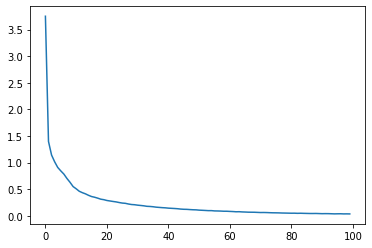

In [32]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket_final.h5")
except (OSError, ValueError) as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [33]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

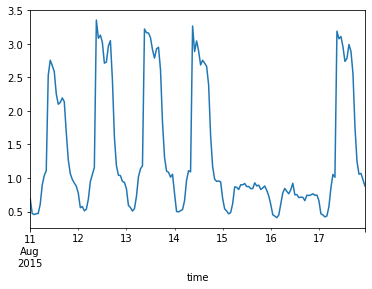

In [34]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4 + socket_pred5) / 5
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

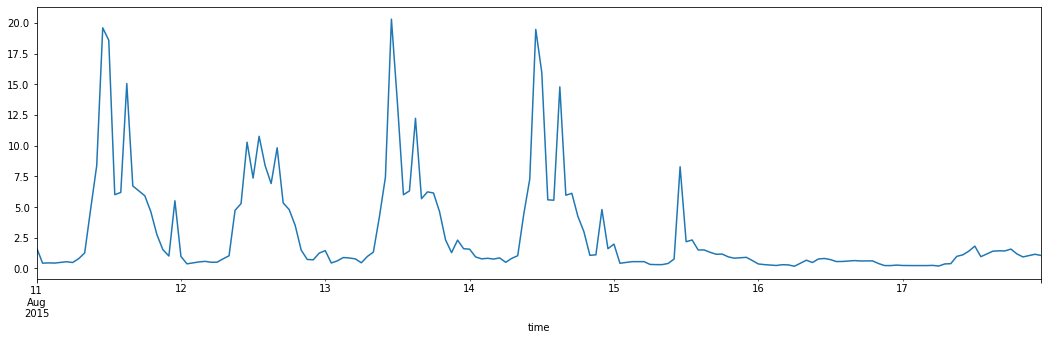

In [35]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [36]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [37]:
model_light1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [38]:
light_pred2 = data_light.loc[: "2015-08-10 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [39]:
model_light3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.063462
0:	learn: 3.5540881	total: 2.64ms	remaining: 2.63s
1:	learn: 3.3893379	total: 5.28ms	remaining: 2.63s
2:	learn: 3.2378582	total: 7.98ms	remaining: 2.65s
3:	learn: 3.0988288	total: 11ms	remaining: 2.75s
4:	learn: 2.9714656	total: 13.5ms	remaining: 2.69s
5:	learn: 2.8552029	total: 16.2ms	remaining: 2.69s
6:	learn: 2.7474674	total: 18.8ms	remaining: 2.67s
7:	learn: 2.6492240	total: 21.4ms	remaining: 2.65s
8:	learn: 2.5586504	total: 23.9ms	remaining: 2.63s
9:	learn: 2.4751033	total: 26.4ms	remaining: 2.61s
10:	learn: 2.3995200	total: 29ms	remaining: 2.6s
11:	learn: 2.3320775	total: 31.3ms	remaining: 2.57s
12:	learn: 2.2688290	total: 33.6ms	remaining: 2.55s
13:	learn: 2.2078791	total: 36ms	remaining: 2.54s
14:	learn: 2.1514743	total: 38.5ms	remaining: 2.52s
15:	learn: 2.1066146	total: 40.7ms	remaining: 2.5s
16:	learn: 2.0581204	total: 43.1ms	remaining: 2.49s
17:	learn: 2.0165321	total: 45.4ms	remaining: 2.48s
18:	learn: 1.9787985	total: 47.6ms	remaining: 2.46s


238:	learn: 1.3022809	total: 523ms	remaining: 1.67s
239:	learn: 1.3010912	total: 525ms	remaining: 1.66s
240:	learn: 1.3003054	total: 527ms	remaining: 1.66s
241:	learn: 1.2989667	total: 530ms	remaining: 1.66s
242:	learn: 1.2983974	total: 532ms	remaining: 1.66s
243:	learn: 1.2978118	total: 534ms	remaining: 1.66s
244:	learn: 1.2974401	total: 536ms	remaining: 1.65s
245:	learn: 1.2967344	total: 539ms	remaining: 1.65s
246:	learn: 1.2964509	total: 541ms	remaining: 1.65s
247:	learn: 1.2957575	total: 543ms	remaining: 1.65s
248:	learn: 1.2949424	total: 545ms	remaining: 1.64s
249:	learn: 1.2944601	total: 547ms	remaining: 1.64s
250:	learn: 1.2935461	total: 549ms	remaining: 1.64s
251:	learn: 1.2923187	total: 552ms	remaining: 1.64s
252:	learn: 1.2905783	total: 554ms	remaining: 1.63s
253:	learn: 1.2899070	total: 556ms	remaining: 1.63s
254:	learn: 1.2888569	total: 558ms	remaining: 1.63s
255:	learn: 1.2882753	total: 560ms	remaining: 1.63s
256:	learn: 1.2880380	total: 562ms	remaining: 1.62s
257:	learn: 

418:	learn: 1.1960864	total: 893ms	remaining: 1.24s
419:	learn: 1.1957167	total: 896ms	remaining: 1.24s
420:	learn: 1.1954010	total: 898ms	remaining: 1.23s
421:	learn: 1.1944975	total: 900ms	remaining: 1.23s
422:	learn: 1.1939223	total: 902ms	remaining: 1.23s
423:	learn: 1.1935025	total: 905ms	remaining: 1.23s
424:	learn: 1.1930561	total: 907ms	remaining: 1.23s
425:	learn: 1.1926516	total: 909ms	remaining: 1.22s
426:	learn: 1.1922794	total: 911ms	remaining: 1.22s
427:	learn: 1.1920163	total: 913ms	remaining: 1.22s
428:	learn: 1.1915704	total: 915ms	remaining: 1.22s
429:	learn: 1.1912506	total: 918ms	remaining: 1.22s
430:	learn: 1.1908481	total: 920ms	remaining: 1.21s
431:	learn: 1.1901785	total: 922ms	remaining: 1.21s
432:	learn: 1.1891393	total: 924ms	remaining: 1.21s
433:	learn: 1.1888415	total: 926ms	remaining: 1.21s
434:	learn: 1.1886167	total: 928ms	remaining: 1.21s
435:	learn: 1.1877357	total: 930ms	remaining: 1.2s
436:	learn: 1.1872738	total: 932ms	remaining: 1.2s
437:	learn: 1.

605:	learn: 1.1233976	total: 1.28s	remaining: 832ms
606:	learn: 1.1231575	total: 1.28s	remaining: 830ms
607:	learn: 1.1229451	total: 1.28s	remaining: 828ms
608:	learn: 1.1224898	total: 1.29s	remaining: 826ms
609:	learn: 1.1222630	total: 1.29s	remaining: 824ms
610:	learn: 1.1217566	total: 1.29s	remaining: 822ms
611:	learn: 1.1211118	total: 1.29s	remaining: 819ms
612:	learn: 1.1205861	total: 1.29s	remaining: 817ms
613:	learn: 1.1202668	total: 1.3s	remaining: 815ms
614:	learn: 1.1201402	total: 1.3s	remaining: 813ms
615:	learn: 1.1197744	total: 1.3s	remaining: 811ms
616:	learn: 1.1196813	total: 1.3s	remaining: 809ms
617:	learn: 1.1194136	total: 1.3s	remaining: 807ms
618:	learn: 1.1191612	total: 1.31s	remaining: 804ms
619:	learn: 1.1187622	total: 1.31s	remaining: 802ms
620:	learn: 1.1187516	total: 1.31s	remaining: 800ms
621:	learn: 1.1186118	total: 1.31s	remaining: 798ms
622:	learn: 1.1181533	total: 1.31s	remaining: 796ms
623:	learn: 1.1177320	total: 1.32s	remaining: 794ms
624:	learn: 1.116

778:	learn: 1.0697786	total: 1.64s	remaining: 464ms
779:	learn: 1.0695514	total: 1.64s	remaining: 462ms
780:	learn: 1.0693408	total: 1.64s	remaining: 460ms
781:	learn: 1.0692260	total: 1.64s	remaining: 458ms
782:	learn: 1.0689005	total: 1.65s	remaining: 456ms
783:	learn: 1.0687694	total: 1.65s	remaining: 454ms
784:	learn: 1.0685088	total: 1.65s	remaining: 452ms
785:	learn: 1.0681091	total: 1.65s	remaining: 450ms
786:	learn: 1.0677514	total: 1.65s	remaining: 448ms
787:	learn: 1.0672573	total: 1.66s	remaining: 446ms
788:	learn: 1.0667542	total: 1.66s	remaining: 444ms
789:	learn: 1.0661455	total: 1.66s	remaining: 442ms
790:	learn: 1.0657396	total: 1.66s	remaining: 440ms
791:	learn: 1.0654576	total: 1.67s	remaining: 437ms
792:	learn: 1.0651160	total: 1.67s	remaining: 435ms
793:	learn: 1.0647057	total: 1.67s	remaining: 433ms
794:	learn: 1.0646286	total: 1.67s	remaining: 431ms
795:	learn: 1.0642264	total: 1.67s	remaining: 429ms
796:	learn: 1.0639805	total: 1.68s	remaining: 427ms
797:	learn: 

948:	learn: 1.0241297	total: 1.99s	remaining: 107ms
949:	learn: 1.0240506	total: 1.99s	remaining: 105ms
950:	learn: 1.0238331	total: 1.99s	remaining: 103ms
951:	learn: 1.0236171	total: 2s	remaining: 101ms
952:	learn: 1.0231997	total: 2s	remaining: 98.5ms
953:	learn: 1.0230126	total: 2s	remaining: 96.4ms
954:	learn: 1.0228040	total: 2s	remaining: 94.3ms
955:	learn: 1.0224803	total: 2s	remaining: 92.2ms
956:	learn: 1.0223554	total: 2.01s	remaining: 90.1ms
957:	learn: 1.0221119	total: 2.01s	remaining: 88ms
958:	learn: 1.0217011	total: 2.01s	remaining: 86ms
959:	learn: 1.0215069	total: 2.01s	remaining: 83.9ms
960:	learn: 1.0214078	total: 2.01s	remaining: 81.8ms
961:	learn: 1.0212867	total: 2.02s	remaining: 79.7ms
962:	learn: 1.0211286	total: 2.02s	remaining: 77.6ms
963:	learn: 1.0208616	total: 2.02s	remaining: 75.5ms
964:	learn: 1.0204768	total: 2.02s	remaining: 73.4ms
965:	learn: 1.0201894	total: 2.02s	remaining: 71.3ms
966:	learn: 1.0199909	total: 2.03s	remaining: 69.2ms
967:	learn: 1.01

<h5>构建xgboost</h5>

In [40]:
model_light4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [41]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 24), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
125/125 [==============================] - 8s 44ms/step - loss: 22.2320 - mae: 3.3283
Epoch 2/100
125/125 [==============================] - 5s 38ms/step - loss: 7.0988 - mae: 1.6778
Epoch 3/100
125/125 [==============================] - 5s 38ms/step - loss: 5.7870 - mae: 1.5147
Epoch 4/100
125/125 [==============================] - 5s 39ms/step - loss: 4.9777 - mae: 1.4062
Epoch 5/100
125/125 [==============================] - 5s 38ms/step - loss: 4.3595 - mae: 1.3201
Epoch 6/100
125/125 [==============================] - 5s 38ms/step - loss: 3.9205 - mae: 1.2534
Epoch 7/100
125/125 [==============================] - 5s 39ms/step - loss: 3.6399 - mae: 1.2116
Epoch 8/100
125/125 [==============================] - 5s 38ms/step - loss: 3.3672 - mae: 1.1653
Epoch 9/100
125/125 [==============================] - 5s 39ms/step - loss: 3.1856 - mae: 1.1314
Epoch 10/100
125/125 [==============================] - 5s 38ms/step - loss: 3.0111 - mae: 1.1022
Epoch 11/100
125/125 [======

125/125 [==============================] - 5s 39ms/step - loss: 0.2992 - mae: 0.3154
Epoch 85/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2874 - mae: 0.3065
Epoch 86/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2808 - mae: 0.3042
Epoch 87/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2839 - mae: 0.3053
Epoch 88/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2722 - mae: 0.2972
Epoch 89/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2775 - mae: 0.2990
Epoch 90/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2747 - mae: 0.2984
Epoch 91/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2678 - mae: 0.2949
Epoch 92/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2706 - mae: 0.2940
Epoch 93/100
125/125 [==============================] - 5s 40ms/step - loss: 0.2667 - mae: 0.2962
Epoch 94/100
125/125 [===========

2023-04-23 17:11:54,073 [INFO] saving LSTM model to ../models/LSTM_light_final.h5


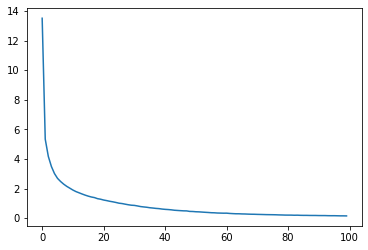

In [42]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_light_final.h5")
except (OSError, ValueError) as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_light_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [43]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

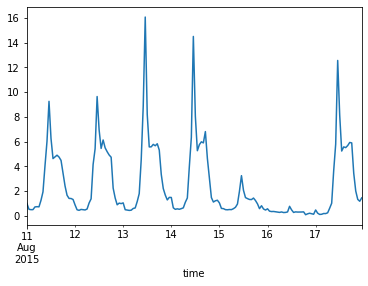

In [44]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4 + light_pred5) / 5
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

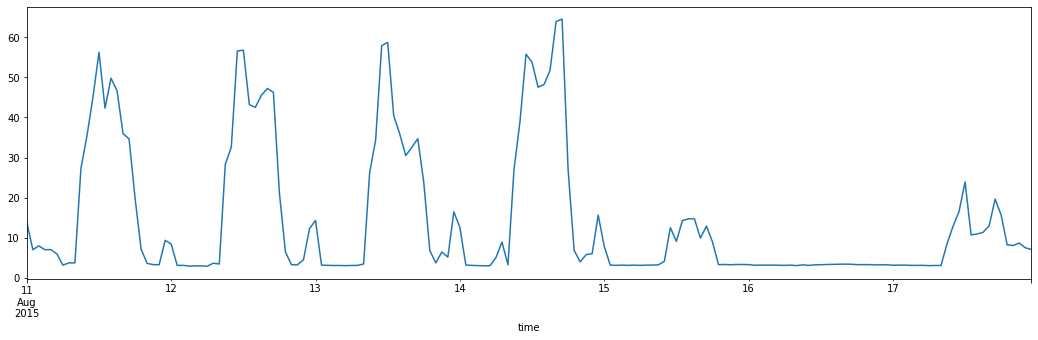

In [45]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [46]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [47]:
model_air1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [48]:
air_pred2 = data_air.loc[: "2015-08-10 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [49]:
model_air3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.063462
0:	learn: 14.1416811	total: 3.19ms	remaining: 3.19s
1:	learn: 13.5891792	total: 6.12ms	remaining: 3.05s
2:	learn: 13.0906005	total: 9.09ms	remaining: 3.02s
3:	learn: 12.6235831	total: 12.2ms	remaining: 3.03s
4:	learn: 12.2081798	total: 15ms	remaining: 2.98s
5:	learn: 11.8215577	total: 17.8ms	remaining: 2.96s
6:	learn: 11.4780872	total: 20.8ms	remaining: 2.95s
7:	learn: 11.1611589	total: 23.6ms	remaining: 2.93s
8:	learn: 10.8474658	total: 26.6ms	remaining: 2.92s
9:	learn: 10.5723534	total: 29.6ms	remaining: 2.92s
10:	learn: 10.3228183	total: 32.4ms	remaining: 2.92s
11:	learn: 10.0821059	total: 35.4ms	remaining: 2.91s
12:	learn: 9.8726658	total: 38.2ms	remaining: 2.9s
13:	learn: 9.6692984	total: 41ms	remaining: 2.89s
14:	learn: 9.4960940	total: 44ms	remaining: 2.89s
15:	learn: 9.3386708	total: 46.7ms	remaining: 2.87s
16:	learn: 9.1786180	total: 49.3ms	remaining: 2.85s
17:	learn: 9.0446674	total: 51.9ms	remaining: 2.83s
18:	learn: 8.9241330	total: 54.5ms	rema

223:	learn: 5.2741189	total: 544ms	remaining: 1.88s
224:	learn: 5.2654632	total: 546ms	remaining: 1.88s
225:	learn: 5.2613126	total: 548ms	remaining: 1.88s
226:	learn: 5.2569698	total: 551ms	remaining: 1.88s
227:	learn: 5.2534124	total: 553ms	remaining: 1.87s
228:	learn: 5.2473107	total: 556ms	remaining: 1.87s
229:	learn: 5.2405553	total: 558ms	remaining: 1.87s
230:	learn: 5.2361258	total: 561ms	remaining: 1.87s
231:	learn: 5.2323034	total: 563ms	remaining: 1.86s
232:	learn: 5.2262973	total: 565ms	remaining: 1.86s
233:	learn: 5.2211638	total: 568ms	remaining: 1.86s
234:	learn: 5.2144738	total: 570ms	remaining: 1.86s
235:	learn: 5.2082114	total: 572ms	remaining: 1.85s
236:	learn: 5.2037302	total: 575ms	remaining: 1.85s
237:	learn: 5.1981276	total: 577ms	remaining: 1.85s
238:	learn: 5.1936257	total: 579ms	remaining: 1.84s
239:	learn: 5.1899548	total: 582ms	remaining: 1.84s
240:	learn: 5.1849582	total: 584ms	remaining: 1.84s
241:	learn: 5.1800598	total: 586ms	remaining: 1.84s
242:	learn: 

454:	learn: 4.3235885	total: 1.09s	remaining: 1.3s
455:	learn: 4.3213827	total: 1.09s	remaining: 1.3s
456:	learn: 4.3205688	total: 1.09s	remaining: 1.3s
457:	learn: 4.3183958	total: 1.09s	remaining: 1.29s
458:	learn: 4.3171668	total: 1.1s	remaining: 1.29s
459:	learn: 4.3136251	total: 1.1s	remaining: 1.29s
460:	learn: 4.3117852	total: 1.1s	remaining: 1.29s
461:	learn: 4.3073434	total: 1.1s	remaining: 1.28s
462:	learn: 4.3055763	total: 1.11s	remaining: 1.28s
463:	learn: 4.3025924	total: 1.11s	remaining: 1.28s
464:	learn: 4.3013580	total: 1.11s	remaining: 1.28s
465:	learn: 4.2987739	total: 1.11s	remaining: 1.27s
466:	learn: 4.2952991	total: 1.11s	remaining: 1.27s
467:	learn: 4.2935157	total: 1.12s	remaining: 1.27s
468:	learn: 4.2916476	total: 1.12s	remaining: 1.27s
469:	learn: 4.2894066	total: 1.12s	remaining: 1.27s
470:	learn: 4.2863402	total: 1.13s	remaining: 1.26s
471:	learn: 4.2845811	total: 1.13s	remaining: 1.26s
472:	learn: 4.2830936	total: 1.13s	remaining: 1.26s
473:	learn: 4.27914

684:	learn: 3.8142693	total: 1.63s	remaining: 751ms
685:	learn: 3.8109386	total: 1.64s	remaining: 748ms
686:	learn: 3.8090944	total: 1.64s	remaining: 746ms
687:	learn: 3.8060738	total: 1.64s	remaining: 744ms
688:	learn: 3.8038579	total: 1.64s	remaining: 741ms
689:	learn: 3.7998212	total: 1.65s	remaining: 739ms
690:	learn: 3.7980913	total: 1.65s	remaining: 737ms
691:	learn: 3.7966330	total: 1.65s	remaining: 734ms
692:	learn: 3.7948237	total: 1.65s	remaining: 732ms
693:	learn: 3.7919242	total: 1.65s	remaining: 730ms
694:	learn: 3.7897669	total: 1.66s	remaining: 727ms
695:	learn: 3.7888931	total: 1.66s	remaining: 725ms
696:	learn: 3.7862857	total: 1.66s	remaining: 722ms
697:	learn: 3.7840109	total: 1.66s	remaining: 720ms
698:	learn: 3.7823370	total: 1.67s	remaining: 718ms
699:	learn: 3.7814136	total: 1.67s	remaining: 715ms
700:	learn: 3.7805489	total: 1.67s	remaining: 713ms
701:	learn: 3.7787917	total: 1.67s	remaining: 710ms
702:	learn: 3.7767920	total: 1.68s	remaining: 708ms
703:	learn: 

913:	learn: 3.4565930	total: 2.17s	remaining: 205ms
914:	learn: 3.4557795	total: 2.18s	remaining: 202ms
915:	learn: 3.4547458	total: 2.18s	remaining: 200ms
916:	learn: 3.4536268	total: 2.18s	remaining: 197ms
917:	learn: 3.4518127	total: 2.18s	remaining: 195ms
918:	learn: 3.4510885	total: 2.19s	remaining: 193ms
919:	learn: 3.4494460	total: 2.19s	remaining: 190ms
920:	learn: 3.4477458	total: 2.19s	remaining: 188ms
921:	learn: 3.4457446	total: 2.19s	remaining: 186ms
922:	learn: 3.4442722	total: 2.2s	remaining: 183ms
923:	learn: 3.4436550	total: 2.2s	remaining: 181ms
924:	learn: 3.4424746	total: 2.2s	remaining: 179ms
925:	learn: 3.4406152	total: 2.2s	remaining: 176ms
926:	learn: 3.4392731	total: 2.21s	remaining: 174ms
927:	learn: 3.4378642	total: 2.21s	remaining: 171ms
928:	learn: 3.4361031	total: 2.21s	remaining: 169ms
929:	learn: 3.4344231	total: 2.21s	remaining: 167ms
930:	learn: 3.4337428	total: 2.22s	remaining: 164ms
931:	learn: 3.4318920	total: 2.22s	remaining: 162ms
932:	learn: 3.43

<h5>构建xgboost</h5>

In [50]:
model_air4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [51]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
125/125 [==============================] - 8s 46ms/step - loss: 444.1198 - mae: 13.2518
Epoch 2/100
125/125 [==============================] - 5s 42ms/step - loss: 255.1714 - mae: 9.8463
Epoch 3/100
125/125 [==============================] - 5s 40ms/step - loss: 104.0036 - mae: 6.3487
Epoch 4/100
125/125 [==============================] - 5s 40ms/step - loss: 80.1221 - mae: 5.5996
Epoch 5/100
125/125 [==============================] - 5s 39ms/step - loss: 70.0913 - mae: 5.2082
Epoch 6/100
125/125 [==============================] - 5s 39ms/step - loss: 56.8497 - mae: 4.7127
Epoch 7/100
125/125 [==============================] - 5s 40ms/step - loss: 50.6767 - mae: 4.4580
Epoch 8/100
125/125 [==============================] - 5s 39ms/step - loss: 42.5676 - mae: 4.0958
Epoch 9/100
125/125 [==============================] - 5s 40ms/step - loss: 37.6012 - mae: 3.8480
Epoch 10/100
125/125 [==============================] - 5s 40ms/step - loss: 34.8439 - mae: 3.7055
Epoch 11/100
12

125/125 [==============================] - 5s 40ms/step - loss: 3.4330 - mae: 1.0863
Epoch 85/100
125/125 [==============================] - 5s 40ms/step - loss: 3.1377 - mae: 1.0405
Epoch 86/100
125/125 [==============================] - 5s 40ms/step - loss: 3.0377 - mae: 1.0235
Epoch 87/100
125/125 [==============================] - 5s 40ms/step - loss: 3.1960 - mae: 1.0518
Epoch 88/100
125/125 [==============================] - 5s 40ms/step - loss: 3.0194 - mae: 1.0165
Epoch 89/100
125/125 [==============================] - 5s 41ms/step - loss: 2.9647 - mae: 1.0047
Epoch 90/100
125/125 [==============================] - 5s 40ms/step - loss: 2.9555 - mae: 1.0050
Epoch 91/100
125/125 [==============================] - 5s 40ms/step - loss: 2.9295 - mae: 0.9998
Epoch 92/100
125/125 [==============================] - 5s 40ms/step - loss: 2.8380 - mae: 0.9892
Epoch 93/100
125/125 [==============================] - 5s 40ms/step - loss: 2.8713 - mae: 0.9898
Epoch 94/100
125/125 [===========

2023-04-23 17:20:30,509 [INFO] saving LSTM model to ../models/LSTM_air_final.h5


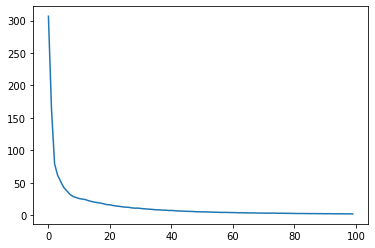

In [52]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_air_final.h5")
except (OSError, ValueError) as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_air5.save_weights("../models/LSTM_air_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_air_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [53]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

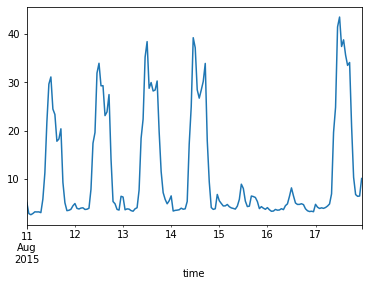

In [54]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4 + air_pred5) / 5
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

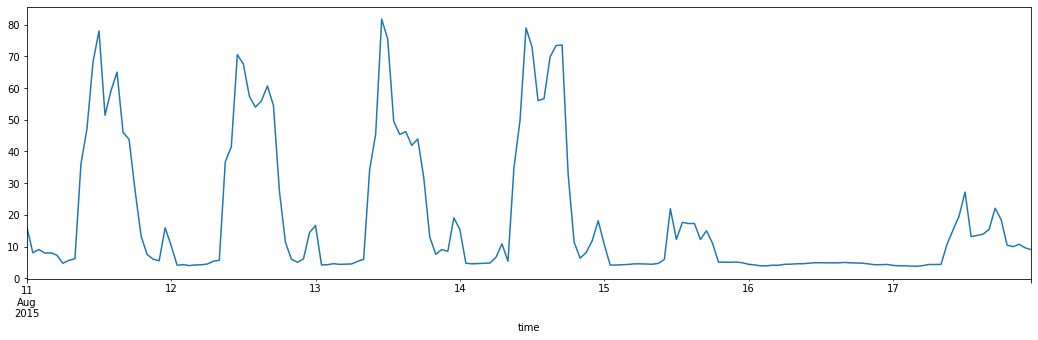

In [55]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [56]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [57]:
model_total1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [58]:
total_pred2 = data_total.loc[: "2015-08-10 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [59]:
model_total3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.063462
0:	learn: 17.9817288	total: 3.54ms	remaining: 3.54s
1:	learn: 17.2099993	total: 6.56ms	remaining: 3.27s
2:	learn: 16.5048232	total: 9.47ms	remaining: 3.15s
3:	learn: 15.8527278	total: 12.3ms	remaining: 3.06s
4:	learn: 15.2581842	total: 15.3ms	remaining: 3.04s
5:	learn: 14.7045589	total: 18.1ms	remaining: 3s
6:	learn: 14.1955833	total: 21ms	remaining: 2.98s
7:	learn: 13.7324394	total: 23.8ms	remaining: 2.95s
8:	learn: 13.3034490	total: 26.6ms	remaining: 2.93s
9:	learn: 12.9195887	total: 29.4ms	remaining: 2.91s
10:	learn: 12.5602116	total: 32.1ms	remaining: 2.89s
11:	learn: 12.2267156	total: 34.7ms	remaining: 2.85s
12:	learn: 11.9280603	total: 37.2ms	remaining: 2.82s
13:	learn: 11.6587269	total: 39.7ms	remaining: 2.79s
14:	learn: 11.4024785	total: 42.1ms	remaining: 2.76s
15:	learn: 11.1712690	total: 44.6ms	remaining: 2.74s
16:	learn: 10.9596261	total: 47.2ms	remaining: 2.73s
17:	learn: 10.7689175	total: 49.6ms	remaining: 2.71s
18:	learn: 10.6025723	total: 52

216:	learn: 5.9785981	total: 531ms	remaining: 1.92s
217:	learn: 5.9725976	total: 533ms	remaining: 1.91s
218:	learn: 5.9678901	total: 536ms	remaining: 1.91s
219:	learn: 5.9622179	total: 538ms	remaining: 1.91s
220:	learn: 5.9582269	total: 540ms	remaining: 1.91s
221:	learn: 5.9536965	total: 543ms	remaining: 1.9s
222:	learn: 5.9504220	total: 545ms	remaining: 1.9s
223:	learn: 5.9408491	total: 548ms	remaining: 1.9s
224:	learn: 5.9294300	total: 550ms	remaining: 1.89s
225:	learn: 5.9232555	total: 552ms	remaining: 1.89s
226:	learn: 5.9142327	total: 555ms	remaining: 1.89s
227:	learn: 5.9082631	total: 557ms	remaining: 1.89s
228:	learn: 5.9001786	total: 559ms	remaining: 1.88s
229:	learn: 5.8937535	total: 562ms	remaining: 1.88s
230:	learn: 5.8896654	total: 564ms	remaining: 1.88s
231:	learn: 5.8820384	total: 566ms	remaining: 1.87s
232:	learn: 5.8771803	total: 569ms	remaining: 1.87s
233:	learn: 5.8718151	total: 571ms	remaining: 1.87s
234:	learn: 5.8678408	total: 573ms	remaining: 1.87s
235:	learn: 5.8

448:	learn: 4.9042244	total: 1.08s	remaining: 1.32s
449:	learn: 4.8996464	total: 1.08s	remaining: 1.32s
450:	learn: 4.8953385	total: 1.08s	remaining: 1.32s
451:	learn: 4.8916484	total: 1.09s	remaining: 1.32s
452:	learn: 4.8897998	total: 1.09s	remaining: 1.32s
453:	learn: 4.8868284	total: 1.09s	remaining: 1.31s
454:	learn: 4.8845643	total: 1.09s	remaining: 1.31s
455:	learn: 4.8812427	total: 1.1s	remaining: 1.31s
456:	learn: 4.8791862	total: 1.1s	remaining: 1.31s
457:	learn: 4.8746416	total: 1.1s	remaining: 1.3s
458:	learn: 4.8725139	total: 1.1s	remaining: 1.3s
459:	learn: 4.8693184	total: 1.11s	remaining: 1.3s
460:	learn: 4.8644250	total: 1.11s	remaining: 1.3s
461:	learn: 4.8613165	total: 1.11s	remaining: 1.29s
462:	learn: 4.8535522	total: 1.11s	remaining: 1.29s
463:	learn: 4.8516628	total: 1.12s	remaining: 1.29s
464:	learn: 4.8496156	total: 1.12s	remaining: 1.29s
465:	learn: 4.8472142	total: 1.12s	remaining: 1.28s
466:	learn: 4.8431744	total: 1.12s	remaining: 1.28s
467:	learn: 4.841833

682:	learn: 4.3333958	total: 1.63s	remaining: 755ms
683:	learn: 4.3322784	total: 1.63s	remaining: 752ms
684:	learn: 4.3292240	total: 1.63s	remaining: 750ms
685:	learn: 4.3280167	total: 1.63s	remaining: 748ms
686:	learn: 4.3266402	total: 1.64s	remaining: 745ms
687:	learn: 4.3253992	total: 1.64s	remaining: 743ms
688:	learn: 4.3229782	total: 1.64s	remaining: 741ms
689:	learn: 4.3207836	total: 1.64s	remaining: 738ms
690:	learn: 4.3178912	total: 1.65s	remaining: 736ms
691:	learn: 4.3164539	total: 1.65s	remaining: 734ms
692:	learn: 4.3146017	total: 1.65s	remaining: 731ms
693:	learn: 4.3135919	total: 1.65s	remaining: 729ms
694:	learn: 4.3102000	total: 1.66s	remaining: 726ms
695:	learn: 4.3066614	total: 1.66s	remaining: 724ms
696:	learn: 4.3045303	total: 1.66s	remaining: 722ms
697:	learn: 4.3012103	total: 1.66s	remaining: 719ms
698:	learn: 4.2977627	total: 1.66s	remaining: 717ms
699:	learn: 4.2955724	total: 1.67s	remaining: 714ms
700:	learn: 4.2953007	total: 1.67s	remaining: 712ms
701:	learn: 

841:	learn: 4.0405446	total: 2s	remaining: 375ms
842:	learn: 4.0390963	total: 2s	remaining: 372ms
843:	learn: 4.0375448	total: 2s	remaining: 370ms
844:	learn: 4.0367578	total: 2s	remaining: 368ms
845:	learn: 4.0341190	total: 2.01s	remaining: 365ms
846:	learn: 4.0318568	total: 2.01s	remaining: 363ms
847:	learn: 4.0293632	total: 2.01s	remaining: 361ms
848:	learn: 4.0279018	total: 2.01s	remaining: 358ms
849:	learn: 4.0252774	total: 2.02s	remaining: 356ms
850:	learn: 4.0235212	total: 2.02s	remaining: 354ms
851:	learn: 4.0222463	total: 2.02s	remaining: 351ms
852:	learn: 4.0185603	total: 2.02s	remaining: 349ms
853:	learn: 4.0166329	total: 2.03s	remaining: 346ms
854:	learn: 4.0149748	total: 2.03s	remaining: 344ms
855:	learn: 4.0132860	total: 2.03s	remaining: 342ms
856:	learn: 4.0121183	total: 2.03s	remaining: 339ms
857:	learn: 4.0089972	total: 2.04s	remaining: 337ms
858:	learn: 4.0072198	total: 2.04s	remaining: 335ms
859:	learn: 4.0060819	total: 2.04s	remaining: 332ms
860:	learn: 4.0044245	to

<h5>构建xgboost</h5>

In [60]:
model_total4 = XGBRegressor(n_estimators=1000, objective='reg:linear', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

[17:20:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


<h5>构建深度模型</h5>

In [61]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
125/125 [==============================] - 8s 45ms/step - loss: 743.6408 - mae: 18.3686
Epoch 2/100
125/125 [==============================] - 5s 40ms/step - loss: 287.2878 - mae: 10.6470
Epoch 3/100
125/125 [==============================] - 5s 40ms/step - loss: 149.4897 - mae: 7.8749
Epoch 4/100
125/125 [==============================] - 5s 40ms/step - loss: 105.3177 - mae: 6.6588
Epoch 5/100
125/125 [==============================] - 5s 40ms/step - loss: 88.0538 - mae: 6.0801
Epoch 6/100
125/125 [==============================] - 5s 40ms/step - loss: 73.5209 - mae: 5.5449
Epoch 7/100
125/125 [==============================] - 5s 41ms/step - loss: 65.2593 - mae: 5.2331
Epoch 8/100
125/125 [==============================] - 5s 41ms/step - loss: 55.7289 - mae: 4.8338
Epoch 9/100
125/125 [==============================] - 5s 40ms/step - loss: 50.4644 - mae: 4.5887
Epoch 10/100
125/125 [==============================] - 5s 40ms/step - loss: 45.8039 - mae: 4.3782
Epoch 11/100


125/125 [==============================] - 5s 40ms/step - loss: 5.2681 - mae: 1.3878
Epoch 85/100
125/125 [==============================] - 5s 41ms/step - loss: 4.8574 - mae: 1.3349
Epoch 86/100
125/125 [==============================] - 5s 40ms/step - loss: 4.6812 - mae: 1.3099
Epoch 87/100
125/125 [==============================] - 5s 40ms/step - loss: 4.6837 - mae: 1.3185
Epoch 88/100
125/125 [==============================] - 5s 41ms/step - loss: 4.5993 - mae: 1.3010
Epoch 89/100
125/125 [==============================] - 5s 41ms/step - loss: 4.5820 - mae: 1.2910
Epoch 90/100
125/125 [==============================] - 5s 40ms/step - loss: 4.5817 - mae: 1.2934
Epoch 91/100
125/125 [==============================] - 5s 41ms/step - loss: 4.6162 - mae: 1.2962
Epoch 92/100
125/125 [==============================] - 5s 41ms/step - loss: 4.4378 - mae: 1.2611
Epoch 93/100
125/125 [==============================] - 5s 40ms/step - loss: 4.4174 - mae: 1.2694
Epoch 94/100
125/125 [===========

2023-04-23 17:29:11,187 [INFO] saving LSTM model to ../models/LSTM_total_final.h5


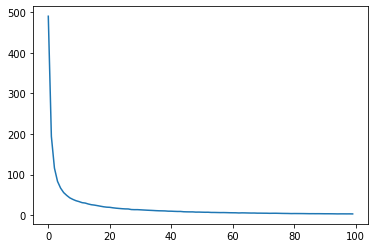

In [62]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_total_final.h5")
except (OSError, ValueError) as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_total_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [63]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

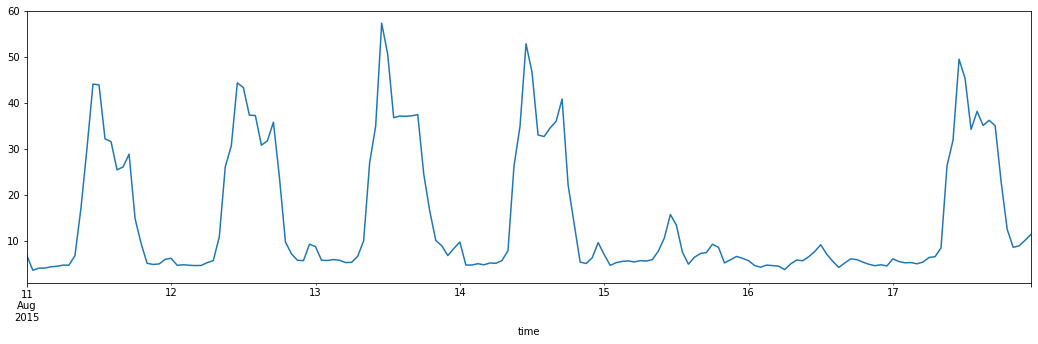

In [64]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4 + total_pred5) / 5
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred
total_pred[120:144] = total_pred2[120:144]
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18, 5))

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [65]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-11 00:00:00,6.807604,0.694300,1.007153,5.140254
2015-08-11 01:00:00,3.603218,0.470015,0.540791,2.838307
2015-08-11 02:00:00,4.055859,0.455320,0.508946,2.605144
2015-08-11 03:00:00,4.079940,0.466132,0.512766,2.850302
2015-08-11 04:00:00,4.350020,0.472069,0.732516,3.200242
...,...,...,...,...
2015-08-17 19:00:00,12.525601,1.250326,3.458605,10.362746
2015-08-17 20:00:00,8.583302,1.056988,2.019461,6.781127
2015-08-17 21:00:00,8.910908,1.068507,1.340338,6.414536
2015-08-17 22:00:00,10.149382,0.971408,1.190268,6.477965


In [66]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)